# EE 123 Lab 1 - Part 3: Distance Measurement

In this part, we'll build a simple acoustic distance meter using the sonar functions from Part 2.

**Goal:** Measure the distance to an object using sound waves and the time-of-flight principle.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sounddevice as sd

fs = 48000
sd.default.samplerate = fs
sd.default.channels = 1

## Step 1: Copy Functions from Part 2

Copy your `genChirpPulse()` and `crossCorr()` functions from Part 2.

In [7]:
def genChirpPulse(Npulse, f0, f1, fs):
    """
    Generate analytic chirp pulse (copy from Part 2).
    """
    # YOUR CODE HERE
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     Npulse = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse  = chirp pulse
    
    # your code here:
    T = Npulse / fs
    t = np.arange(Npulse) / fs
    k = (f1 - f0) / T
    phi_of_t = 2 * np.pi * (f0 * t + k * t**2)
    s_chirp = np.exp(1j * phi_of_t)
    # pulse = signal.hilbert(s_chirp)
    
    return s_chirp
    pass


def crossCorr(rcv, pulse_a):
    """
    Cross-correlation using convolution (copy from Part 2).
    """
    # YOUR CODE HERE
    # Funtion generates cross-correlation between rcv and pulse_a.
    # Inputs:
    #     rcv     = received signal
    #     pulse_a = analytic pulse
    # Output:
    #     Xrcv    = cross-correlation between rcv and pulse_a
    
    # your code here:
    Xrcv = signal.fftconvolve(rcv, np.conj(pulse_a[::-1]), mode='full')
    # end of your code
    
    return Xrcv
    pass

## Step 2: Speed of Sound

The speed of sound depends on temperature:

$$v = 331.3 + 0.606 \cdot T \quad \text{(m/s)}$$

where $T$ is temperature in Celsius.

In [8]:
def speed_of_sound(temp_celsius):
    """Return speed of sound in m/s at given temperature."""
    # YOUR CODE HERE (one line)
    return 331.3 + 0.606 * temp_celsius
    pass

# Test: should print ~343.4 m/s
print(f"Speed at 20°C: {speed_of_sound(20):.1f} m/s")

Speed at 20°C: 343.4 m/s


## Step 3: Delay to Distance

Sound travels to the object and back, so:

$$d = \frac{v \cdot \Delta t}{2}$$

In [9]:
def delay_to_distance(delay_samples, fs, temp_celsius):
    """
    Convert delay (in samples) to distance (in meters).
    
    Steps:
    1. Convert samples to time: delay_time = delay_samples / fs
    2. Get speed: v = speed_of_sound(temp_celsius)
    3. Calculate distance: d = v * delay_time / 2
    """
    # YOUR CODE HERE
    delay_time = delay_samples / fs
    v = speed_of_sound(temp_celsius)
    distance = v * delay_time / 2
    return distance

## Step 4: Measure Distance

Complete the function below. The key step is finding the echo peak in the cross-correlation:

1. The **first peak** in `|corr|` is the direct signal (delay ≈ 0)
2. The **second peak** is the echo from the object
3. The delay between them gives you the distance

In [10]:
def measure_distance(temp_celsius=20, f0=100, f1=10000, duration=0.1):
    """
    Measure distance to nearest object.
    Returns: (distance_in_meters, cross_correlation)
    """
    Npulse = int(fs * duration)
    pulse = genChirpPulse(Npulse, f0, f1, fs)
    
    # Recording buffer: pulse + time for sound to travel 5m and back
    max_delay = int(2 * 5 / speed_of_sound(temp_celsius) * fs)
    tx = np.zeros(Npulse + max_delay)
    tx[:Npulse] = pulse.real
    
    # Play and record
    rcv = sd.playrec(tx, fs, channels=1, blocking=True).flatten()
    
    # Cross-correlation
    corr = crossCorr(rcv, pulse)
    corr_abs = np.abs(corr)
    
    # === YOUR CODE HERE ===

    # Find the echo peak:
    # 1. first_peak = index of maximum in corr_abs (direct signal)
    # 2. Search for second peak after (first_peak + Npulse)
    # 3. delay_samples = second_peak - first_peak
    first_peak = np.argmax(corr_abs)
    second_peak = np.argmax(corr_abs[first_peak + Npulse:]) + first_peak + Npulse
    delay_samples = second_peak - first_peak
    # delay_samples = 0  # Replace this!
    
    # === END YOUR CODE ===
    
    distance = delay_to_distance(delay_samples, fs, temp_celsius)
    return distance, corr

## Step 5: Test It!

Point your speaker/mic at a wall or hold your hand in front. Try different distances.

**Tips:**
- Works best at 0.5 - 2 meters
- Use hard, flat surfaces
- Keep speaker and mic pointing the same direction

In [12]:
room_temp = 20  # adjust to your room

distance, corr = measure_distance(temp_celsius=room_temp)
print(f"Distance: {distance:.2f} m ({distance*100:.0f} cm)")

Distance: 31.63 m (3163 cm)


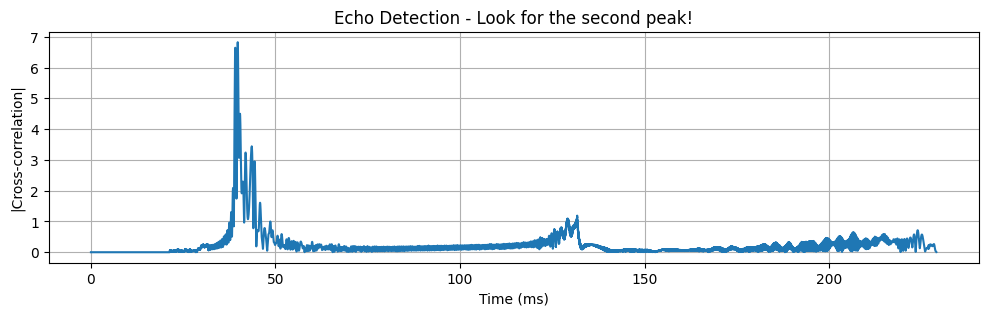

In [13]:
# Visualize the cross-correlation
plt.figure(figsize=(12, 3))
t_ms = np.arange(len(corr)) / fs * 1000
plt.plot(t_ms, np.abs(corr))
plt.xlabel('Time (ms)')
plt.ylabel('|Cross-correlation|')
plt.title('Echo Detection - Look for the second peak!')
plt.grid(True)
plt.show()